In [1]:
########### Visualizing dyad. ###########

In [2]:
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import skimage
import numpy as np
from typing import List
import random
from tqdm import tqdm
import scipy.io as sio

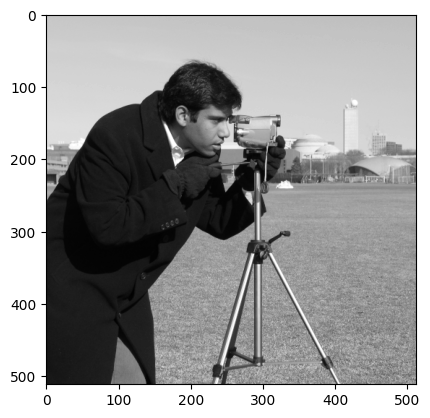

(512, 512), (512,), (512, 512)
(512, 512)


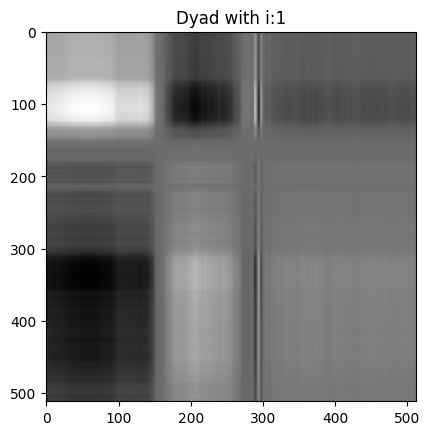

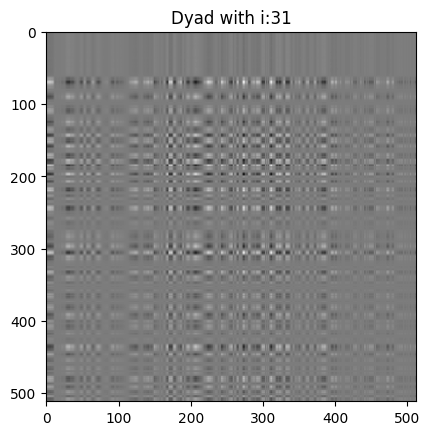

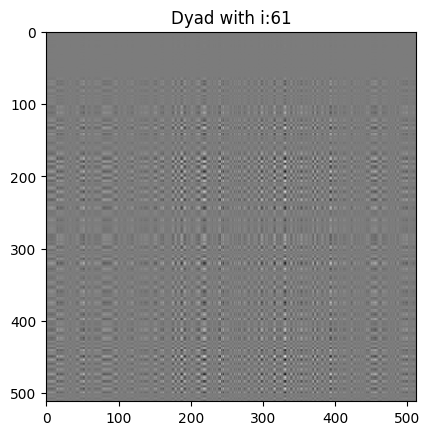

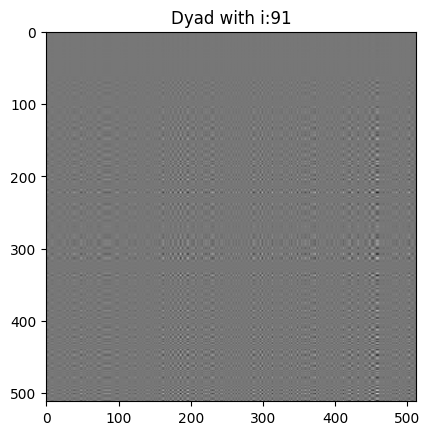

In [3]:
#### ESERCIZIO 1 ####
img = skimage.data.camera()
plt.imshow(img, cmap="gray")
plt.show()

U, s, VT = np.linalg.svd(img)
print(f"{U.shape}, {s.shape}, {VT.shape}")
S = np.diag(s)
print(S.shape)


"""
Se X è nxm: U deve avere la forma nxn, S nxm e VT mxm così otteniamo nxm come output.
Quindi quando facciamo slicing lasciamo la dimesione originale di righe a U, e la dimensione originale di colonne a VT
in  questo modo continuiamo ad avere in output una matrice nxm.
In questo caso prendiamo solamente i e non :i perchè volgiamo visualizzare solamente il valore del dyad per quello specifico valore
di i e non la sommatoria dei dyad fino a i.
"""
for i in np.arange(1, 100, 30):
  plt.imshow((U[:, i:i+1] @ VT[i:i+1, :]) *S[i, i], cmap="gray")
  plt.title(f'Dyad with i:{ i}')
  plt.show()



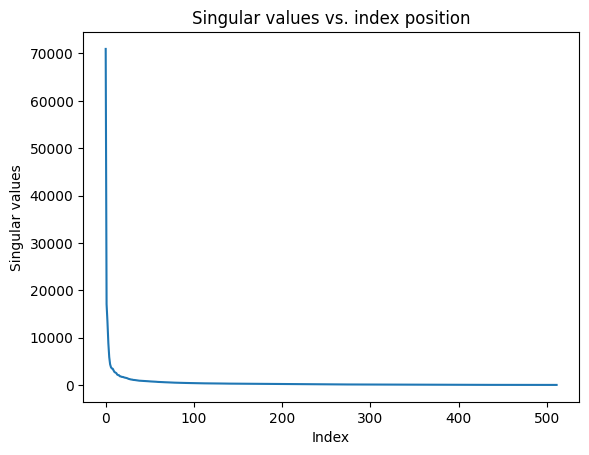

In [4]:
plt.plot(range(len(s)),s)
plt.title('Singular values vs. index position')
plt.xlabel('Index')
plt.ylabel('Singular values')
plt.show()

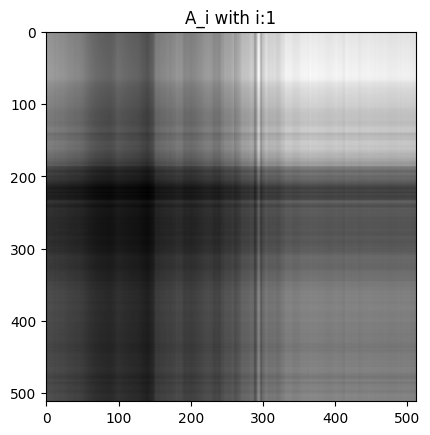

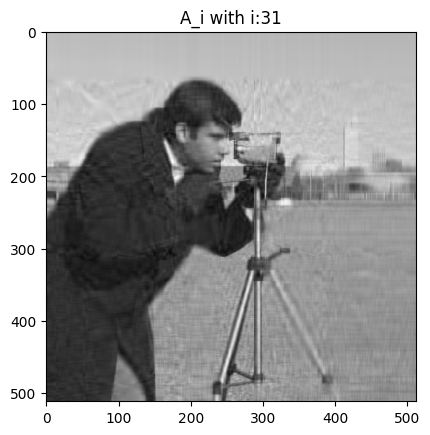

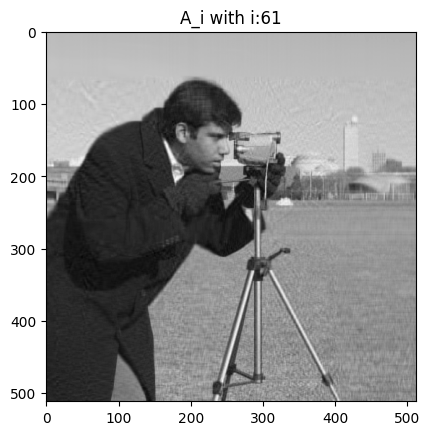

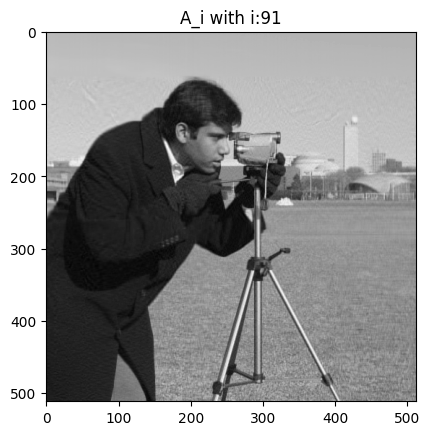

In [5]:
"""
Se X è nxm: U deve avere la forma nxn, S nxm e VT mxm così otteniamo nxm come output.
Quindi quando facciamo slicing lasciamo la dimesione originale di righe a U, e la dimensione originale di colonne a VT
in  questo modo continuiamo ad avere in output una matrice nxm.
"""
for i in np.arange(1, 100, 30):
  plt.imshow(U[:, :i] @ S[:i, :i] @ VT[:i, :], cmap="gray")
  plt.title(f'A_i with i:{ i}')
  plt.show()

512 512


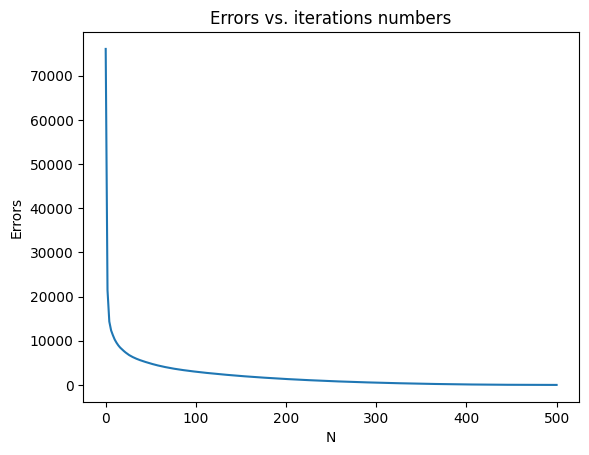

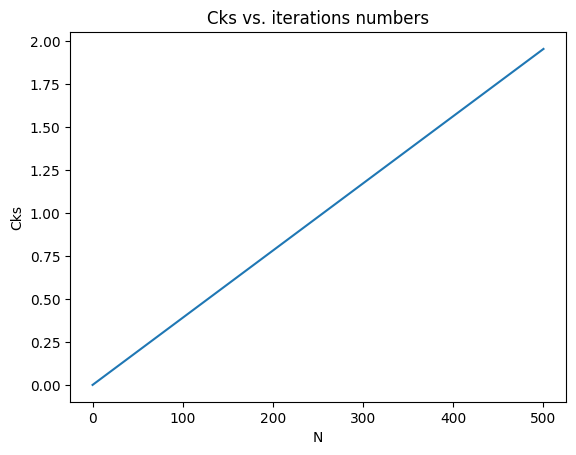

In [6]:
nums = np.arange(0, 501, 2)
errs, cks = [], []
n, m = img.shape
print(m, n)
for k in nums:
  X_k = U[:, :k] @ S[:k, :k] @ VT[:k, :]
  errs.append(np.linalg.norm((img - X_k), 'fro'))
  # Fattore di compressione
  cks.append((k*(m + n + 1) / (m*n)))
plt.plot(nums, errs)
plt.title('Errors vs. iterations numbers')
plt.xlabel('N')
plt.ylabel('Errors')
plt.show()

plt.plot(nums, cks)
plt.title('Cks vs. iterations numbers')
plt.xlabel('N')
plt.ylabel('Cks')
plt.show()

In [7]:
########### Classification of MNIST Digits with SVD Decomposition. ###########

In [9]:
data = sio.loadmat('MNIST.mat')

In [82]:
label = data['I']
print(type(label))
x_data = data['X']
print(type(x_data))
print(x_data.shape, label.shape)
numbers = [1, 3, 6]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(256, 1707) (1, 1707)


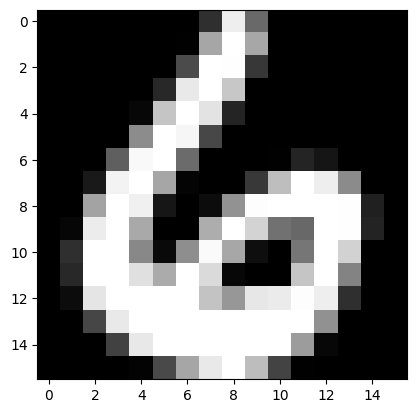

In [11]:
def visualize_vector(vec):
  img = vec.reshape(16, 16)
  plt.imshow(img, cmap="gray")
visualize_vector(x_data[:, 0])

In [52]:
"""
  Given a dataset x of feature, a dataset y of labels and a list of integers
  the function return a dataset y containing only labels equals to the integer
  present in the list and their corresponding feature.
"""
def filter_data(x, y, filter: List[int]):
  y = y.ravel() # Return a contiguous flattened array.

  # Create a boolean mask for rows where y is 3 or 4
  mask = False
  for elem in filter:
    mask = mask | (y == elem)

  # Use the mask to filter x and y
  filtered_x = x[:, mask]
  filtered_y = y[mask]

  # If you want to reshape filtered_y back to (1, N) where N is the number of selected rows
  filtered_y = filtered_y.reshape(1, -1)

  print(filtered_x.shape, filtered_y.shape)
  return filtered_x, filtered_y

fil_x, fil_y = filter_data(x_data, label, numbers)
print(np.unique(fil_y))

(256, 374) (1, 374)
[1 4]


In [53]:
def split_dataset(x_dataset, label_dataset, train_rateo):
  dataset = np.concatenate((x_dataset, label_dataset), axis=0)
  train_split = int(len(dataset[0])*train_rateo)
  return dataset[:, :train_split][:-1], dataset[:, :train_split][-1], dataset[:, train_split:][:-1], dataset[:, train_split:][-1]
x_train, y_train, x_test, y_test = split_dataset(fil_x, fil_y, 0.8)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(np.unique(y_test))

(256, 299) (299,) (256, 75) (75,)
[1. 4.]


In [54]:
"""
  Given a dataset x of feature, a dataset y containing N unique labels and an
  integer train_rateo 0<=train_rateo<=1 the function return a list of N dataset
  x,y each containing only one unique label.
"""
def separate_dataset(x, y):
  unique = np.unique(y)
  y = y.ravel()
  mask_list, c_list, yc_list = [], [], []
  for n in unique:
    mask_list.append(y == n)

  for mask in mask_list:
    c_list.append(x[:, mask])
    yc_list.append(y[mask].reshape(1, -1))

  #for i in range(len(unique)):
  #  print(c_list[i].shape, yc_list[i].shape)

  return c_list, yc_list

c_list, y_list = separate_dataset(x_train, y_train)

In [15]:
def classify_digit(c_list, y, target, c_label):
  dist_list = []

  for c in c_list:
    U = np.linalg.svd(c, full_matrices=False)[0]
    y_orto = U@(U.T@y)
    dist_list.append(np.linalg.norm(y - y_orto, 2))

  res = c_label[np.argmin(dist_list)]

  #print(y, res)
  if res == target:
    return True
  else:
    return False

correct = 0
for i in tqdm(range(len(x_test[0]))):
  if classify_digit(c_list, x_test[:, i].T, y_test[i], np.unique(y_test)):
    correct += 1
print()
print(f"Accuracy: {correct/len(x_test[0].T)}")

100%|██████████| 108/108 [00:03<00:00, 27.88it/s]


Accuracy: 0.8888888888888888


In [ ]:
####### Clustering with PCA #######

In [55]:
df = pd.read_csv(r'sample_data/mnist_test.csv')
display(df)
df = df.to_numpy().T
#plt.imshow(df.head(1).drop('7', axis=1).to_numpy().reshape(28, 28))

,7,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9995,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
X, Y = df[1:], df[:1]
print(X.shape, Y.shape)

(784, 9999) (1, 9999)


In [84]:
x, y = filter_data(X, Y, numbers)

(784, 3103) (1, 3103)


In [85]:
x_train, y_train, x_test, y_test = split_dataset(x, y, 0.8)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(784, 2482) (2482,) (784, 621) (621,)


In [86]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(784, 2482) (2482,) (784, 621) (621,)


In [21]:
def centroid(data):
  return data.mean(axis=1)

In [43]:
def pca(data, k=2, U=np.empty(1)):
  Xc = (data.T - centroid(data)).T # traspongo data.T e rifaccio .T per rimettere in forma originale
  print(Xc.shape)
  if U.shape==(1,):
    U, _, _ = np.linalg.svd(Xc, full_matrices=False)
  Zk = U[:, :k].T @ Xc
  print(f"New shape of data: {Zk.shape}")
  return Zk, U

In [23]:
def get_mean_distance(data, point):
  dist = []
  for item in data.T:
    dist.append(np.linalg.norm(item - point[:, np.newaxis], 2))
  return np.mean(dist)

(784, 2482)
New shape of data: (2, 2482)
(784, 621)
New shape of data: (2, 621)
Average distance of cluster 1 from centroid: 1172.000402585418
Average distance of cluster 1 from test centroid: 1370.1822739577126

Average distance of cluster 3 from centroid: 1158.1727167439767
Average distance of cluster 3 from test centroid: 1869.7034047707261

Average distance of cluster 6 from centroid: 809.9969637284431
Average distance of cluster 6 from test centroid: 1519.369303608024



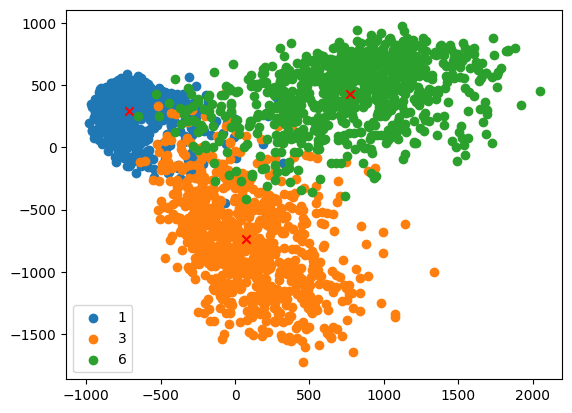

In [87]:
def plot_cluster():
  unique_labels = np.unique(y_train)
  # Calcolo pca per train e test riducendoli a 2 feature
  Zk, U = pca(x_train)
  Zk_test, _ = pca(x_test)


  x_list, y_list = separate_dataset(Zk, y_train)
  x_test_list, y_test_list = separate_dataset(Zk_test, y_test)

  # Calcolo la posizione dei centroidi per ogni cluster nel train
  centroid_list = [centroid(x) for x in x_list]

  # Create a scatter plot for each unique label
  for label, subdata, c, subdata_test in zip(unique_labels, x_list, centroid_list, x_test_list):
      mask = (y_train == label)
      plt.scatter(Zk[0, mask], Zk[1, mask], label=f'{str(label)[0]}')
      plt.scatter(c[0], c[1], marker='x', color='red')

      # Calcolo la distanza tra il cluster e il centroide di quel cluster
      distance = get_mean_distance(subdata, c)
      distance_test = get_mean_distance(subdata_test, c)
      print(f"Average distance of cluster {str(label)[0]} from centroid: {distance}")
      print(f"Average distance of cluster {str(label)[0]} from test centroid: {distance_test}", end='\n\n')

  # Add a legend to the plot
  plt.legend()
  # Show the plot
  plt.show()
  return centroid_list, [centroid(x) for x in x_test_list], U

centroid_list, test_centroid_list, U = plot_cluster()

In [88]:
def get_accuracy(centroid_list, U):
  xk, U_test = pca(x_test, U=U)
  lables = np.unique(y_test)
  print(lables)

  correct = 0
  for i in range(len(xk.T)):
    distances = [np.linalg.norm(xk[:, i] - c, 2) for c in centroid_list]
    res = lables[np.argmin(distances)]
    if res == y_test[i]:
      correct += 1
  print(f"Accuracy: {correct/len(xk.T)}")

get_accuracy(test_centroid_list, U)

(784, 621)
New shape of data: (2, 621)
[1 3 6]
Accuracy: 0.4557165861513688


(784, 2482)
New shape of data: (3, 2482)
(784, 621)
New shape of data: (3, 621)
Average distance of cluster 1 from centroid: 1855.6615577502905
Average distance of cluster 1 from test centroid: 2013.8963816144844

Average distance of cluster 3 from centroid: 1673.5432953261814
Average distance of cluster 3 from test centroid: 2172.548441970492

Average distance of cluster 6 from centroid: 1530.59032190291
Average distance of cluster 6 from test centroid: 1955.3718454229822



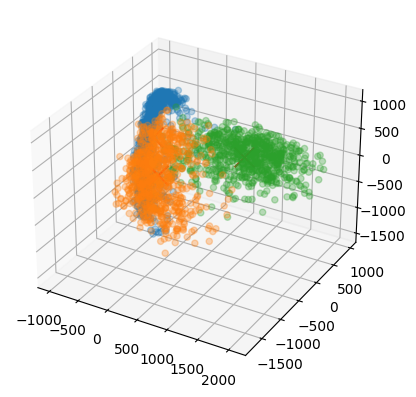

In [89]:
def plot_cluster_3d():
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  # Calcolo pca per train e test riducendoli a 3 feature
  unique_labels = np.unique(y_train)
  Zk, U_3d = pca(x_train, 3)
  Zk_test, _ = pca(x_test, 3)

  x_list, y_list = separate_dataset(Zk, y_train)
  x_test_list, y_test_list = separate_dataset(Zk_test, y_test)

  # Calcolo il centroide per ogni cluster del train set, shape (3,) visto che è calcolato su dati a 3 feature
  centroid_list = [centroid(x) for x in x_list]

  # Create a scatter plot for each unique label
  for label, subdata, c, subdata_test in zip(unique_labels, x_list, centroid_list, x_test_list):
      mask = (y_train == label)
      ax.scatter(Zk[0, mask], Zk[1, mask], Zk[2, mask], label=f'{str(label)[0]}', alpha=0.3)
      ax.scatter(c[0], c[1], c[2], marker='x', color='red', s=200, alpha=1.0)

      # Calcolo la distanza tra il cluster e il centroide di quel cluster
      distance = get_mean_distance(subdata, c)
      distance_test = get_mean_distance(subdata_test, c)
      print(f"Average distance of cluster {str(label)[0]} from centroid: {np.mean(distance)}")
      print(f"Average distance of cluster {str(label)[0]} from test centroid: {np.mean(distance_test)}", end='\n\n')
  return centroid_list, [centroid(x) for x in x_test_list], U_3d

centroid_list, test_centroid_list, U_3d = plot_cluster_3d()

In [90]:
def get_accuracy_3d(centroid_list, U_3d):
  xk, _ = pca(x_test, 3, U_3d)
  lables = np.unique(y_test)
  print(lables)

  correct = 0
  for i in range(len(xk.T)):
    distances = [np.linalg.norm(xk[:, i] - c, 2) for c in centroid_list]
    res = lables[np.argmin(distances)]
    if res == y_test[i]:
      correct += 1
  print(f"Accuracy: {correct/len(xk.T)}")

get_accuracy_3d(test_centroid_list, U_3d)

(784, 621)
New shape of data: (3, 621)
[1 3 6]
Accuracy: 0.46215780998389694


In [ ]:
###### TEST WITH 2 CLUSTER ######

(784, 1693)
New shape of data: (2, 1693)
(784, 424)
New shape of data: (2, 424)
Average distance of cluster 1 from centroid: 1248.250115450354
Average distance of cluster 1 from test centroid: 1390.4494155481827

Average distance of cluster 4 from centroid: 1105.1050172662144
Average distance of cluster 4 from test centroid: 1173.4593403695624



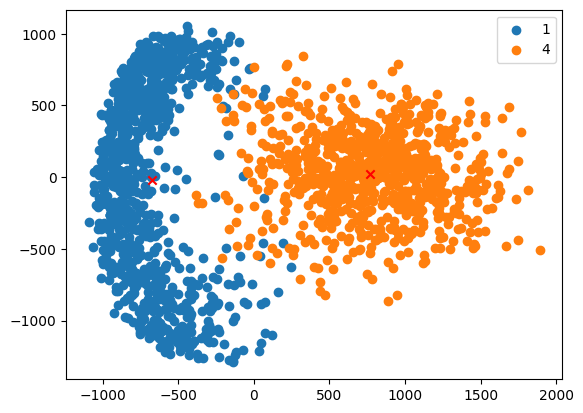

In [66]:
centroid_list, test_centroid_list, U = plot_cluster()

In [67]:
get_accuracy(test_centroid_list, U)

(784, 424)
New shape of data: (2, 424)
[1 4]
Accuracy: 0.9740566037735849


(784, 1693)
New shape of data: (3, 1693)
(784, 424)
New shape of data: (3, 424)
Average distance of cluster 1 from centroid: 1692.6909904997704
Average distance of cluster 1 from test centroid: 1812.4453508380582

Average distance of cluster 4 from centroid: 1745.1138943308313
Average distance of cluster 4 from test centroid: 1902.2675758357586



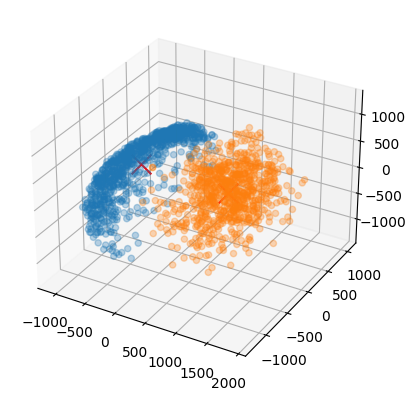

In [63]:
centroid_list, test_centroid_list, U_3d = plot_cluster_3d()

In [64]:
get_accuracy_3d(test_centroid_list, U_3d)

(784, 424)
New shape of data: (3, 424)
[1 4]
Accuracy: 0.9693396226415094


In [ ]:
###### TEST WITH PCA K=1 ######

(784, 2482)
New shape of data: (1, 2482)
(784, 621)
New shape of data: (1, 621)
Average distance of cluster 1 from centroid: 143.4583749946102
Average distance of cluster 1 from test centroid: 235.01586066356478

Average distance of cluster 3 from centroid: 258.7578189721073
Average distance of cluster 3 from test centroid: 310.1847877308324

Average distance of cluster 6 from centroid: 385.05434470660697
Average distance of cluster 6 from test centroid: 420.78808747857806



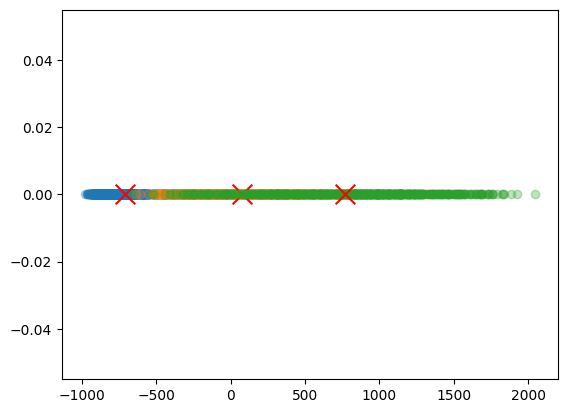

In [91]:
def plot_cluster_1d():
  fig = plt.figure()
  ax = fig.add_subplot()

  # Calcolo pca per train e test riducendoli a 3 feature
  unique_labels = np.unique(y_train)
  Zk, U_1d = pca(x_train, 1)
  Zk_test, _ = pca(x_test, 1)

  x_list, y_list = separate_dataset(Zk, y_train)
  x_test_list, y_test_list = separate_dataset(Zk_test, y_test)

  # Calcolo il centroide per ogni cluster del train set, shape (3,) visto che è calcolato su dati a 3 feature
  centroid_list = [centroid(x) for x in x_list]

  # Create a scatter plot for each unique label
  for label, subdata, c, subdata_test in zip(unique_labels, x_list, centroid_list, x_test_list):
      mask = (y_train == label)
      ax.scatter(Zk[0, mask], np.zeros(Zk[0, mask].shape),  label=f'{str(label)[0]}', alpha=0.3)
      ax.scatter(c[0], 0, marker='x', color='red', s=200, alpha=1.0)

      # Calcolo la distanza tra il cluster e il centroide di quel cluster
      distance = get_mean_distance(subdata, c)
      distance_test = get_mean_distance(subdata_test, c)
      print(f"Average distance of cluster {str(label)[0]} from centroid: {np.mean(distance)}")
      print(f"Average distance of cluster {str(label)[0]} from test centroid: {np.mean(distance_test)}", end='\n\n')
  return centroid_list, [centroid(x) for x in x_test_list], U_1d

centroid_list, test_centroid_list, U_1d = plot_cluster_1d()

In [92]:
def get_accuracy_1d(centroid_list, U_1d):
  xk, _ = pca(x_test, 1, U_1d)
  lables = np.unique(y_test)
  print(lables)

  correct = 0
  for i in range(len(xk.T)):
    distances = [np.linalg.norm(xk[:, i] - c, 2) for c in centroid_list]
    res = lables[np.argmin(distances)]
    if res == y_test[i]:
      correct += 1
  print(f"Accuracy: {correct/len(xk.T)}")

get_accuracy_1d(test_centroid_list, U_1d)

(784, 621)
New shape of data: (1, 621)
[1 3 6]
Accuracy: 0.8985507246376812
